In [2]:
import pandas as pd

In [3]:
df = pd.read_csv("Online Retail.csv", encoding='ISO-8859-1')
df.head(), df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


(  InvoiceNo StockCode                          Description  Quantity  \
 0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
 1    536365     71053                  WHITE METAL LANTERN         6   
 2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
 3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
 4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
 
       InvoiceDate  UnitPrice  CustomerID         Country  
 0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
 1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
 2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
 3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
 4  12/1/2010 8:26       3.39     17850.0  United Kingdom  ,
 None)

In [4]:
# Clean the dataset
data_cleaned = df.dropna(subset=['CustomerID'])

data_cleaned = data_cleaned[data_cleaned['Quantity'] > 0]

data_cleaned['InvoiceDate'] = pd.to_datetime(data_cleaned['InvoiceDate'])

data_cleaned['TotalPrice'] = data_cleaned['Quantity'] * data_cleaned['UnitPrice']

data_cleaned.info(), data_cleaned.head()


<class 'pandas.core.frame.DataFrame'>
Index: 397924 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397924 non-null  object        
 1   StockCode    397924 non-null  object        
 2   Description  397924 non-null  object        
 3   Quantity     397924 non-null  int64         
 4   InvoiceDate  397924 non-null  datetime64[ns]
 5   UnitPrice    397924 non-null  float64       
 6   CustomerID   397924 non-null  float64       
 7   Country      397924 non-null  object        
 8   TotalPrice   397924 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 30.4+ MB


(None,
   InvoiceNo StockCode                          Description  Quantity  \
 0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
 1    536365     71053                  WHITE METAL LANTERN         6   
 2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
 3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
 4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
 
           InvoiceDate  UnitPrice  CustomerID         Country  TotalPrice  
 0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom       15.30  
 1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom       20.34  
 2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom       22.00  
 3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom       20.34  
 4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom       20.34  )

In [5]:
# Reference date for Recency calculation (max date in the dataset + 1 day)
reference_date = data_cleaned['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm = data_cleaned.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  
    'InvoiceNo': 'nunique',                                   
    'TotalPrice': 'sum'                                    
}).rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalPrice': 'Monetary'
}).reset_index()

rfm.head()


,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12347.0,2,7,4310.00
2,12348.0,75,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,310,1,334.40


In [6]:
from sklearn.preprocessing import MinMaxScaler

# Normalize the RFM metrics
scaler = MinMaxScaler()
rfm_normalized = rfm.copy()
rfm_normalized[['Recency', 'Frequency', 'Monetary']] = scaler.fit_transform(
    rfm[['Recency', 'Frequency', 'Monetary']])

rfm_normalized.head()


,CustomerID,Recency,Frequency,Monetary
0,12346.0,0.871314,0.000000,0.275453
1,12347.0,0.002681,0.028708,0.015382
2,12348.0,0.198391,0.014354,0.006414
3,12349.0,0.048257,0.000000,0.006272
4,12350.0,0.828418,0.000000,0.001193


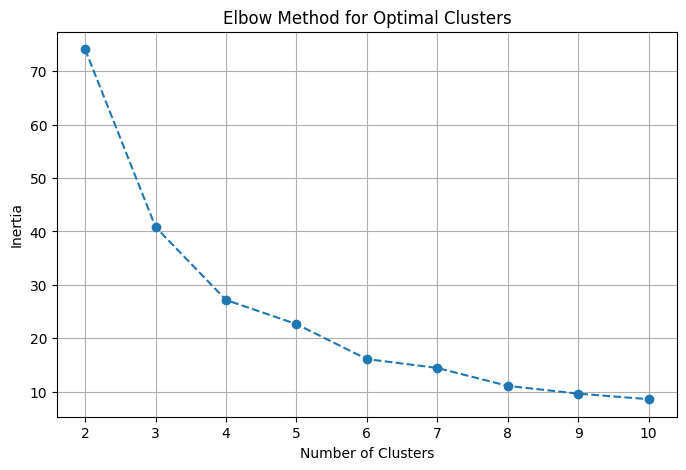

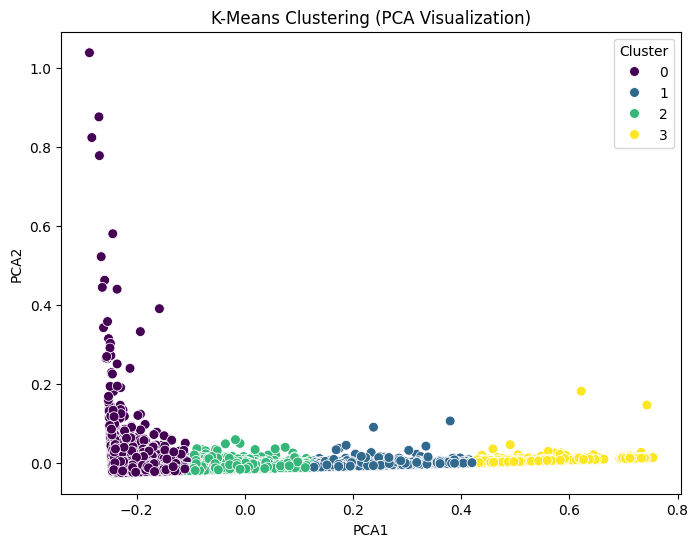

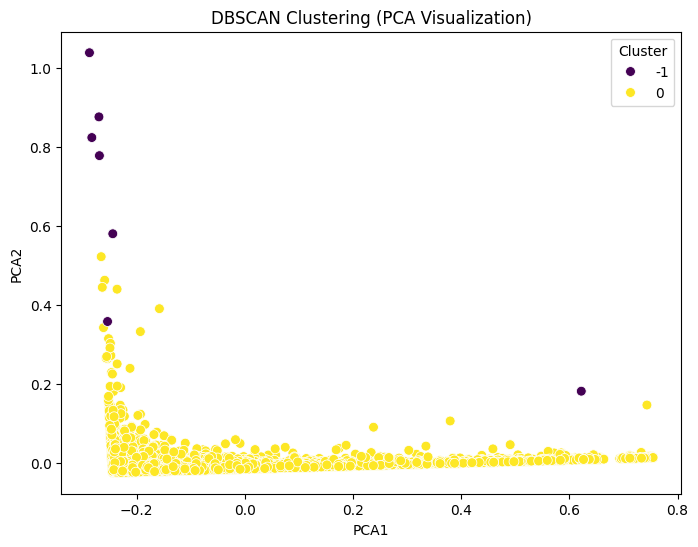

K-Means Cluster Characteristics:
                  Recency  Frequency  Monetary
KMeans_Cluster                               
0               0.052012   0.025621  0.011548
1               0.516095   0.004137  0.002574
2               0.223911   0.007649  0.003575
3               0.825694   0.001675  0.002022


In [7]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# K-Means Clustering
inertia = []
range_clusters = range(2, 11)  
for k in range_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_normalized[['Recency', 'Frequency', 'Monetary']])
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(range_clusters, inertia, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.grid()
plt.show()

# Fit K-Means with the optimal number of clusters (e.g., k=4)
kmeans = KMeans(n_clusters=4, random_state=42)
rfm_normalized['KMeans_Cluster'] = kmeans.fit_predict(rfm_normalized[['Recency', 'Frequency', 'Monetary']])

# DBSCAN Clustering
dbscan = DBSCAN(eps=0.2, min_samples=5)
rfm_normalized['DBSCAN_Cluster'] = dbscan.fit_predict(rfm_normalized[['Recency', 'Frequency', 'Monetary']])

# Visualize K-Means Clusters using PCA for dimensionality reduction
pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(rfm_normalized[['Recency', 'Frequency', 'Monetary']])
rfm_normalized['PCA1'] = rfm_pca[:, 0]
rfm_normalized['PCA2'] = rfm_pca[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='PCA1', y='PCA2',
    hue='KMeans_Cluster',
    data=rfm_normalized,
    palette='viridis',
    s=50
)
plt.title('K-Means Clustering (PCA Visualization)')
plt.legend(title='Cluster')
plt.show()

# Visualize DBSCAN Clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='PCA1', y='PCA2',
    hue='DBSCAN_Cluster',
    data=rfm_normalized,
    palette='viridis',
    s=50
)
plt.title('DBSCAN Clustering (PCA Visualization)')
plt.legend(title='Cluster')
plt.show()

# Analyze Cluster Insights
kmeans_clusters = rfm_normalized.groupby('KMeans_Cluster').mean()[['Recency', 'Frequency', 'Monetary']]
print("K-Means Cluster Characteristics:\n", kmeans_clusters)


In [13]:
from sklearn.decomposition import PCA

# Assuming 'rfm' is your preprocessed dataframe with RFM features
# Apply PCA to reduce dimensionality to 2 or 3 components
pca = PCA(n_components=3)  # Use 3 components for 3D visualization, or 2 for 2D
pca_result = pca.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

# Add the PCA components to the dataframe for later use
rfm['PCA1'] = pca_result[:, 0]
rfm['PCA2'] = pca_result[:, 1]
rfm['PCA3'] = pca_result[:, 2]  # This will be used for 3D plot

from sklearn.cluster import KMeans

# Perform KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42)  # Assuming 4 clusters
rfm['KMeans_Cluster'] = kmeans.fit_predict(rfm[['Recency', 'Frequency', 'Monetary']])


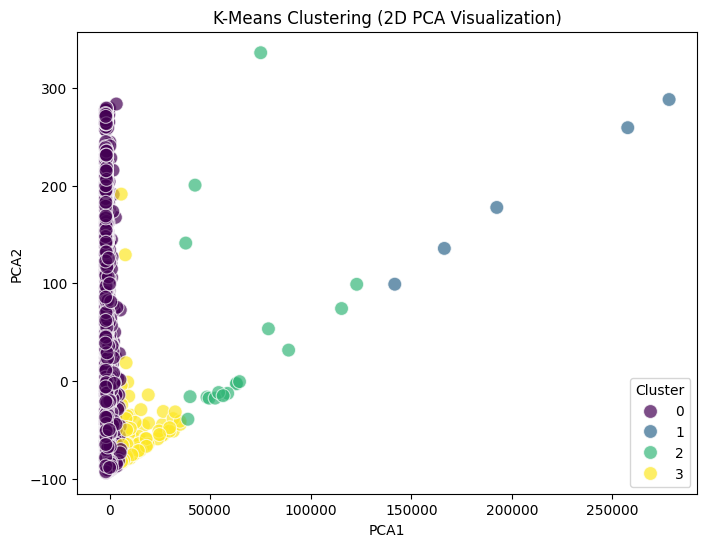

In [14]:
# 2D PCA Visualization
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=rfm['PCA1'],  # First Principal Component
    y=rfm['PCA2'],  # Second Principal Component
    hue=rfm['KMeans_Cluster'],  # Cluster Labels
    palette='viridis',  # Color Palette
    s=100,              # Marker Size
    alpha=0.7           # Transparency
)
plt.title("K-Means Clustering (2D PCA Visualization)")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.legend(title="Cluster")
plt.show()


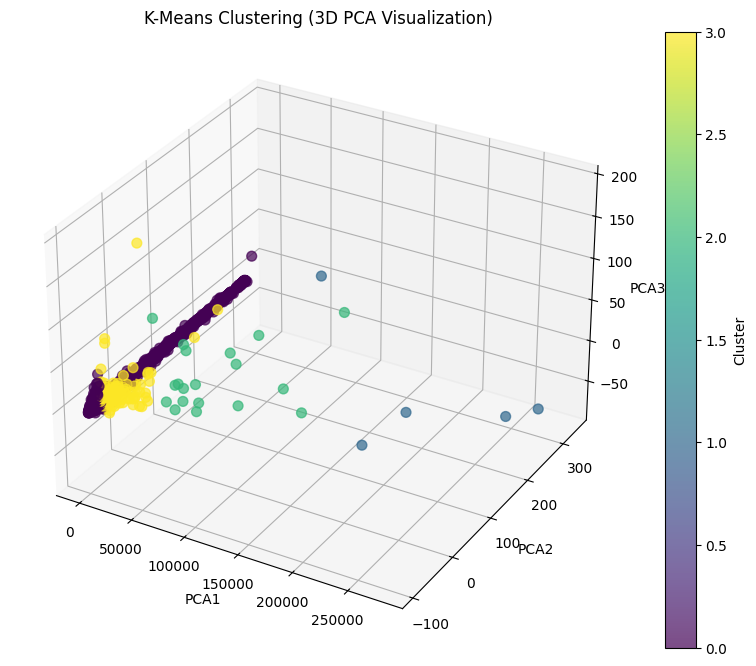

In [15]:
# 3D PCA Visualization
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    rfm['PCA1'],  # PCA1
    rfm['PCA2'],  # PCA2
    rfm['PCA3'],  # PCA3
    c=rfm['KMeans_Cluster'],  # Cluster Labels
    cmap='viridis',    # Color Map
    s=50,              # Marker Size
    alpha=0.7          # Transparency
)

# Labels and Title
ax.set_title("K-Means Clustering (3D PCA Visualization)")
ax.set_xlabel("PCA1")
ax.set_ylabel("PCA2")
ax.set_zlabel("PCA3")
fig.colorbar(scatter, ax=ax, label="Cluster")
plt.show()


In [16]:
# Grouping by KMeans cluster labels and calculating the mean of the features
cluster_characteristics = rfm.groupby('KMeans_Cluster')[['Recency', 'Frequency', 'Monetary']].mean()

print(cluster_characteristics)


                  Recency  Frequency       Monetary
KMeans_Cluster                                     
0               95.025757   3.482709    1167.251771
1                2.600000  76.600000  209342.334000
2               46.789474  40.789474   65622.708421
3               17.147541  22.745902   14127.689344


In [18]:
cluster_summary = rfm.groupby('KMeans_Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
}).reset_index()
print(cluster_summary)


   KMeans_Cluster    Recency  Frequency       Monetary
0               0  95.025757   3.482709    1167.251771
1               1   2.600000  76.600000  209342.334000
2               2  46.789474  40.789474   65622.708421
3               3  17.147541  22.745902   14127.689344


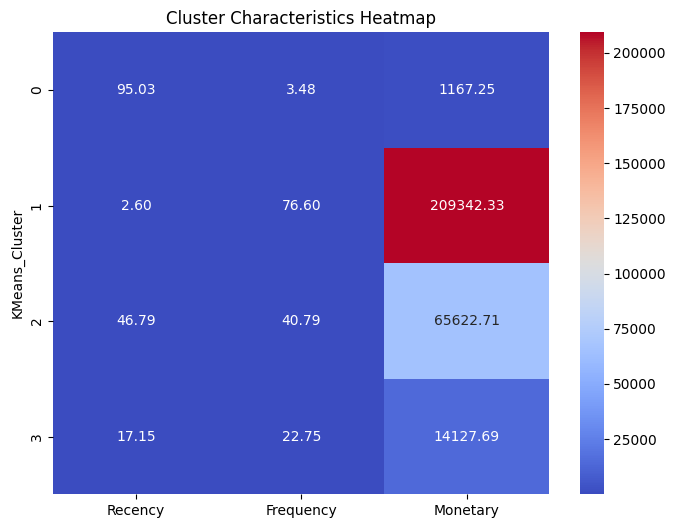

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(cluster_characteristics, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title("Cluster Characteristics Heatmap")
plt.show()
